Final Cum. BESS Energy (MWh): -312,471.11
Final Cum. CO₂ burden (time-varying, t): -7,852.95
Final Cum. CO₂ burden (average CI, t): 40,504.94
Average CI (gCO₂ /kWh): 129.63


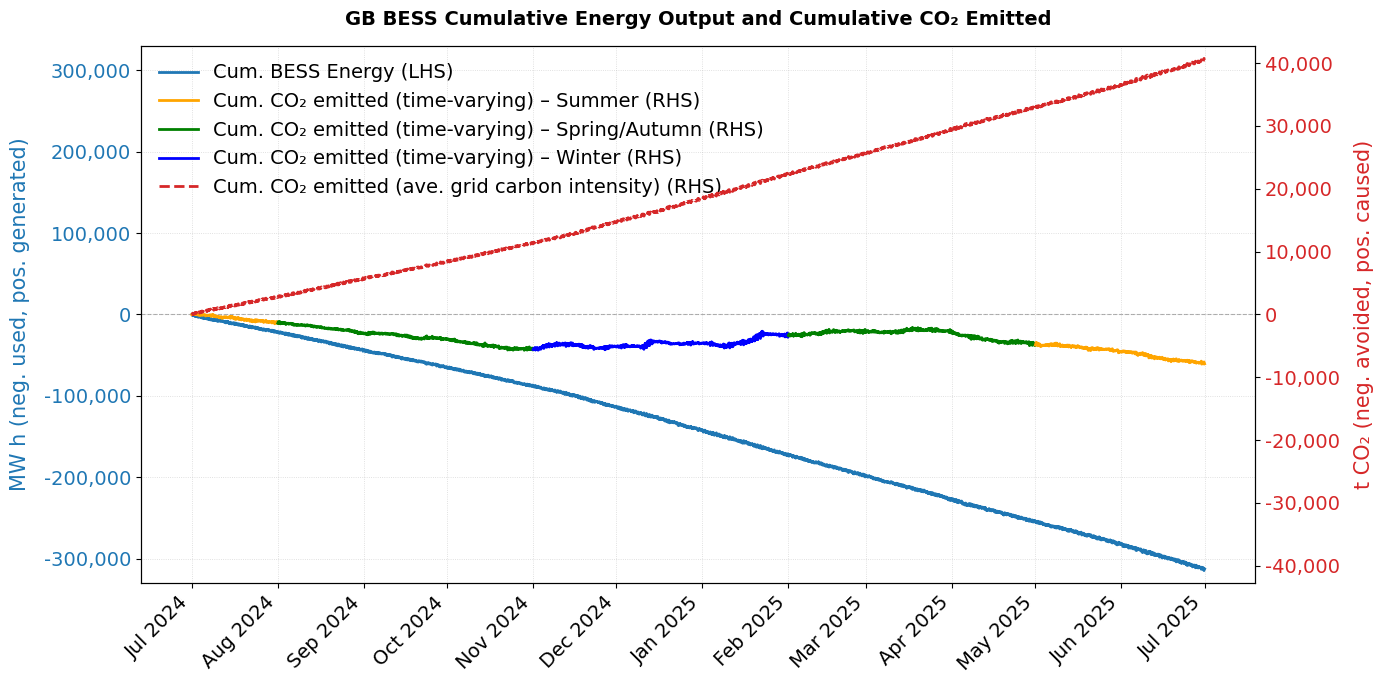

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# === GLOBAL FONT SIZES (min 12) ===
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse SettlementDate and create datetime ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')

# === Assign season based on datetime ===
def classify_season(dt):
    m = dt.month
    if m in [11, 12, 1]:
        return 'Winter'
    elif m in [5, 6, 7]:
        return 'Summer'
    else:
        return 'Spring/Autumn'

df['Season'] = df['datetime'].apply(classify_season)

# === Compute cumulative values ===
df = df.sort_values('datetime')
df['NetEnergy_MWh'] = df['BESSDischargeGB'] + df['BESSChargeGB']
df['Cum. BESS Energy'] = df['NetEnergy_MWh'].cumsum()

# Convert from kg to tonnes by dividing by 1000
df['CO2_Actual_t'] = (df['NetEnergy_MWh'] * df['CarbonIntensityActualGB']) / 1000
df['Cum. CO2 Actual'] = -df['CO2_Actual_t'].cumsum()

avg_carbon_intensity = df['CarbonIntensityActualGB'].mean()
df['CO2_Avg_t'] = (df['NetEnergy_MWh'] * avg_carbon_intensity) / 1000
df['Cum. CO2 Avg'] = -df['CO2_Avg_t'].cumsum()

# === Get data ranges ===
energy = df['Cum. BESS Energy']
co2_actual = df['Cum. CO2 Actual']
co2_avg = df['Cum. CO2 Avg']
co2_combined = pd.concat([co2_actual, co2_avg])

# === Compute symmetric y-axis limits ===
energy_max = energy.abs().max()
co2_max = co2_combined.abs().max()
energy_lim = (-energy_max, energy_max)
co2_lim = (-co2_max, co2_max)

# === Season color mapping ===
season_colors = {
    'Winter': 'blue',
    'Summer': 'orange',
    'Spring/Autumn': 'green'
}

# === Plotting ===
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot primary axis (Cum. BESS Energy)
line1, = ax1.plot(df['datetime'], energy, color='tab:blue', label='Cum. BESS Energy (LHS)', linewidth=2)
ax1.set_ylabel("MW h (neg. used, pos. generated)", color='tab:blue', fontsize=15, labelpad=10)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax1.set_ylim(energy_lim[0]*1.05, energy_lim[1]*1.05)

# Plot seasonal CO₂ burden segments on secondary axis
ax2 = ax1.twinx()
season_lines = []
plotted_seasons = set()
last_idx = 0

for i in range(1, len(df)):
    season_now = df['Season'].iloc[i]
    season_prev = df['Season'].iloc[i - 1]
    is_last = i == len(df) - 1

    if season_now != season_prev or is_last:
        segment = df.iloc[last_idx:i+1] if is_last else df.iloc[last_idx:i]
        season = segment['Season'].iloc[0]
        label = f"Cum. CO₂ emitted (time-varying) – {season} (RHS)" if season not in plotted_seasons else None
        line, = ax2.plot(segment['datetime'], segment['Cum. CO2 Actual'],
                         color=season_colors[season],
                         label=label,
                         linewidth=2)
        if season not in plotted_seasons:
            season_lines.append(line)
            plotted_seasons.add(season)
        last_idx = i

# Plot average CO₂ burden line
line_avg, = ax2.plot(df['datetime'], co2_avg,
                     color='tab:red',
                     linestyle='--',
                     label='Cum. CO₂ emitted (ave. grid carbon intensity) (RHS)',
                     linewidth=2)

ax2.set_ylabel("t CO\u2082 (neg. avoided, pos. caused)", color='tab:red', fontsize=15, labelpad=10)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.set_ylim(co2_lim[0]*1.05, co2_lim[1]*1.05)

# Grid and formatting
ax1.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.6)
ax1.grid(True, which='major', axis='both', linestyle=':', linewidth=0.6, alpha=0.5)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=14)

# Title and layout
plt.title("GB BESS Cumulative Energy Output and Cumulative CO\u2082 Emitted", fontsize=14, weight='bold', pad=15)
fig.tight_layout()

# Legend
all_lines = [line1] + season_lines + [line_avg]
labels = [line.get_label() for line in all_lines]
ax1.legend(all_lines, labels, loc='upper left', fontsize=14, frameon=False)

# === Print final cumulative values ===
final_energy = df['Cum. BESS Energy'].iloc[-1]
final_co2_actual = df['Cum. CO2 Actual'].iloc[-1]
final_co2_avg = df['Cum. CO2 Avg'].iloc[-1]

print(f"Final Cum. BESS Energy (MWh): {final_energy:,.2f}")
print(f"Final Cum. CO₂ burden (time-varying, t): {final_co2_actual:,.2f}")
print(f"Final Cum. CO₂ burden (average CI, t): {final_co2_avg:,.2f}")
print(f"Average CI (gCO₂ /kWh): {avg_carbon_intensity :,.2f}")

plt.show()



Final Cum. BESS Energy (MWh): -312,471.11
Final Cum. CO₂ burden (time-varying, t): -7,852.95
Final Cum. CO₂ burden (average CI, t): 40,504.94
Average CI (gCO₂ /kWh): 129.63


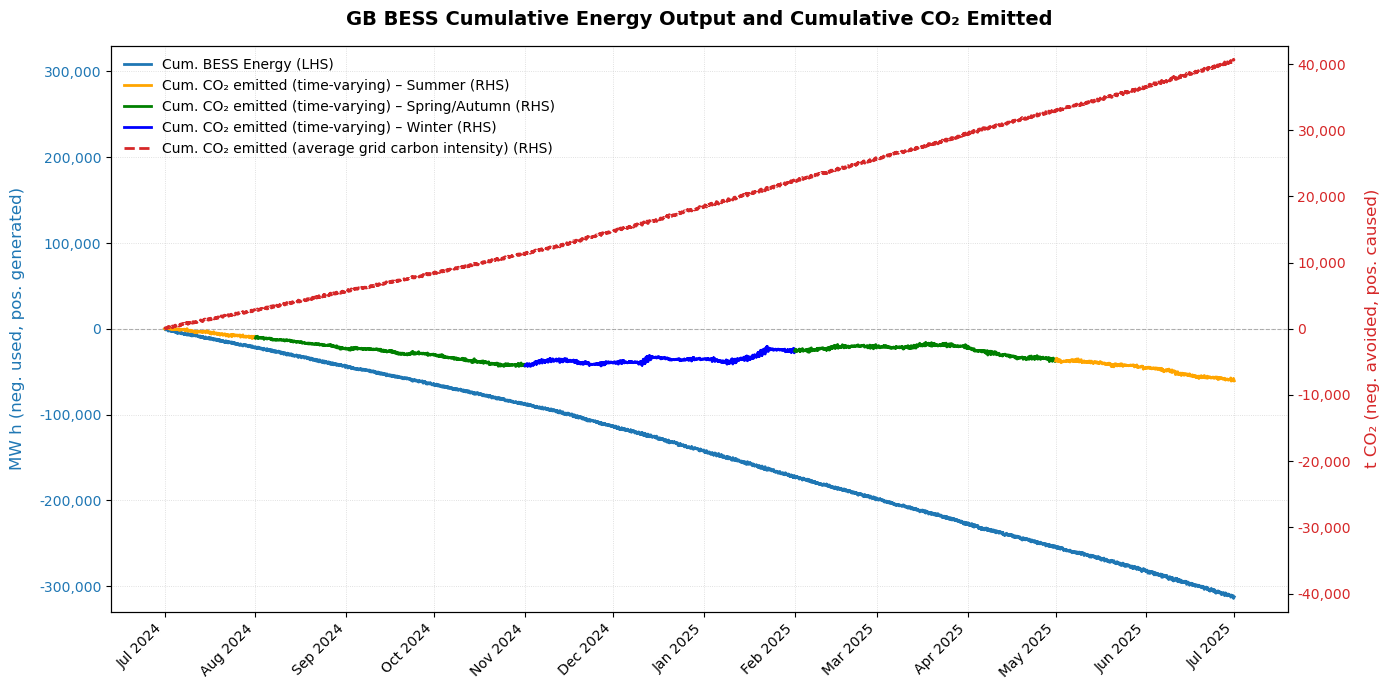

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse SettlementDate and create datetime ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')

# === Assign season based on datetime ===
def classify_season(dt):
    m = dt.month
    if m in [11, 12, 1]:
        return 'Winter'
    elif m in [5, 6, 7]:
        return 'Summer'
    else:
        return 'Spring/Autumn'

df['Season'] = df['datetime'].apply(classify_season)

# === Compute cumulative values ===
df = df.sort_values('datetime')
df['NetEnergy_MWh'] = df['BESSDischargeGB'] + df['BESSChargeGB']
df['Cum. BESS Energy'] = df['NetEnergy_MWh'].cumsum()

# Convert from kg to tonnes by dividing by 1000
df['CO2_Actual_t'] = (df['NetEnergy_MWh'] * df['CarbonIntensityActualGB']) / 1000
df['Cum. CO2 Actual'] = -df['CO2_Actual_t'].cumsum()

avg_carbon_intensity = df['CarbonIntensityActualGB'].mean()
df['CO2_Avg_t'] = (df['NetEnergy_MWh'] * avg_carbon_intensity) / 1000
df['Cum. CO2 Avg'] = -df['CO2_Avg_t'].cumsum()

# === Get data ranges ===
energy = df['Cum. BESS Energy']
co2_actual = df['Cum. CO2 Actual']
co2_avg = df['Cum. CO2 Avg']
co2_combined = pd.concat([co2_actual, co2_avg])

# === Compute symmetric y-axis limits ===
energy_max = energy.abs().max()
co2_max = co2_combined.abs().max()
energy_lim = (-energy_max, energy_max)
co2_lim = (-co2_max, co2_max)

# === Season color mapping ===
season_colors = {
    'Winter': 'blue',
    'Summer': 'orange',
    'Spring/Autumn': 'green'
}

# === Plotting ===
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot primary axis (Cum. BESS Energy)
line1, = ax1.plot(df['datetime'], energy, color='tab:blue', label='Cum. BESS Energy (LHS)', linewidth=2)
ax1.set_ylabel("MW h (neg. used, pos. generated)", color='tab:blue', fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=10)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax1.set_ylim(energy_lim[0]*1.05, energy_lim[1]*1.05)

# Plot seasonal CO₂ burden segments on secondary axis
ax2 = ax1.twinx()
season_lines = []
plotted_seasons = set()
last_idx = 0

for i in range(1, len(df)):
    season_now = df['Season'].iloc[i]
    season_prev = df['Season'].iloc[i - 1]
    is_last = i == len(df) - 1

    if season_now != season_prev or is_last:
        segment = df.iloc[last_idx:i+1] if is_last else df.iloc[last_idx:i]
        season = segment['Season'].iloc[0]
        label = f"Cum. CO₂ emitted (time-varying) – {season} (RHS)" if season not in plotted_seasons else None
        line, = ax2.plot(segment['datetime'], segment['Cum. CO2 Actual'],
                         color=season_colors[season],
                         label=label,
                         linewidth=2)
        if season not in plotted_seasons:
            season_lines.append(line)
            plotted_seasons.add(season)
        last_idx = i

# Plot average CO₂ burden line
line_avg, = ax2.plot(df['datetime'], co2_avg,
                     color='tab:red',
                     linestyle='--',
                     label='Cum. CO₂ emitted (average grid carbon intensity) (RHS)',
                     linewidth=2)

ax2.set_ylabel("t CO\u2082 (neg. avoided, pos. caused)", color='tab:red', fontsize=12, labelpad=10)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=10)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.set_ylim(co2_lim[0]*1.05, co2_lim[1]*1.05)

# Grid and formatting
ax1.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.6)
ax1.grid(True, which='major', axis='both', linestyle=':', linewidth=0.6, alpha=0.5)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Title and layout
plt.title("GB BESS Cumulative Energy Output and Cumulative CO\u2082 Emitted", fontsize=14, weight='bold', pad=15)
fig.tight_layout()

# Legend
all_lines = [line1] + season_lines + [line_avg]
labels = [line.get_label() for line in all_lines]
ax1.legend(all_lines, labels, loc='upper left', fontsize=10, frameon=False)

# === Print final cumulative values ===
final_energy = df['Cum. BESS Energy'].iloc[-1]
final_co2_actual = df['Cum. CO2 Actual'].iloc[-1]
final_co2_avg = df['Cum. CO2 Avg'].iloc[-1]

print(f"Final Cum. BESS Energy (MWh): {final_energy:,.2f}")
print(f"Final Cum. CO₂ burden (time-varying, t): {final_co2_actual:,.2f}")
print(f"Final Cum. CO₂ burden (average CI, t): {final_co2_avg:,.2f}")
print(f"Average CI (gCO₂ /kWh): {avg_carbon_intensity :,.2f}")

plt.show()



Final Cum. BESS Energy (MWh): -312,471.11
Final Cum. CO₂ burden (time-varying, kg): -7,852,954.82
Final Cum. CO₂ burden (average CI, kg): 40,504,941.29
Average CI (gCO₂ /kWh): 129.63


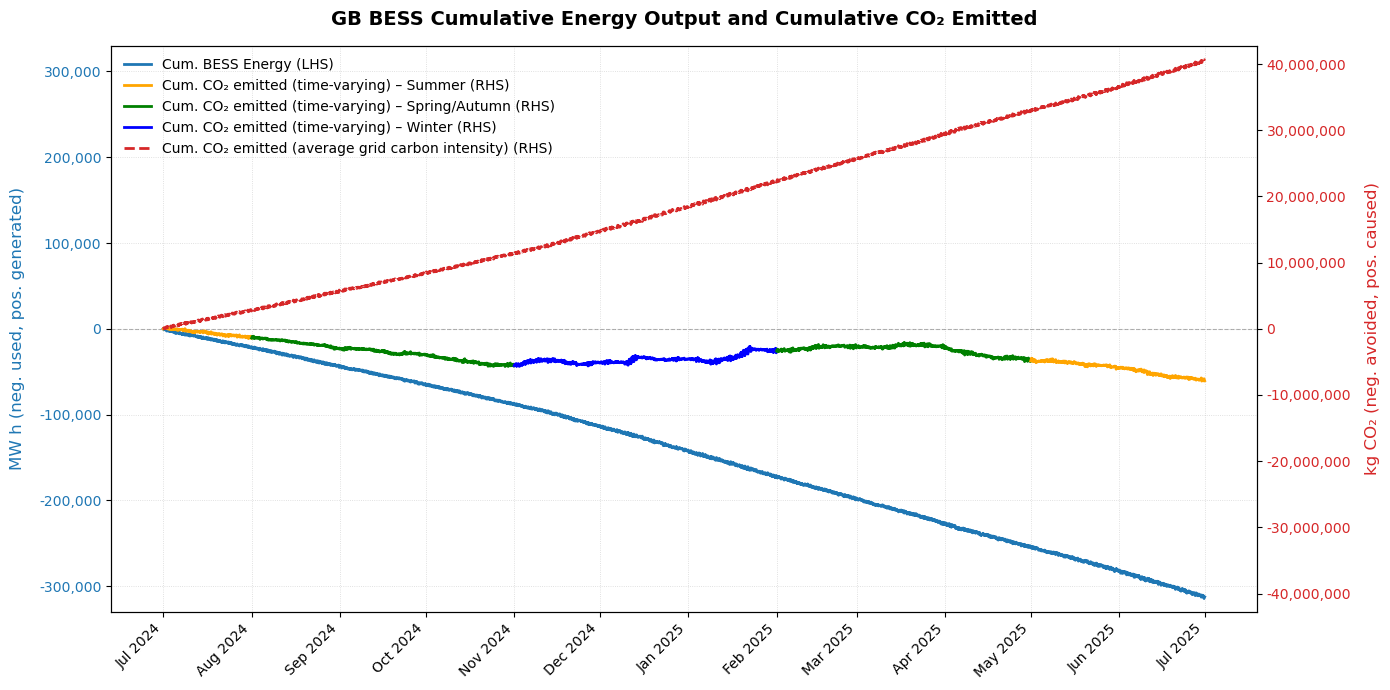

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse SettlementDate and create datetime ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')

# === Assign season based on datetime ===
def classify_season(dt):
    m = dt.month
    if m in [11, 12, 1]:
        return 'Winter'
    elif m in [5, 6, 7]:
        return 'Summer'
    else:
        return 'Spring/Autumn'

df['Season'] = df['datetime'].apply(classify_season)

# === Compute cumulative values ===
df = df.sort_values('datetime')
df['NetEnergy_MWh'] = df['BESSDischargeGB'] + df['BESSChargeGB']
df['Cum. BESS Energy'] = df['NetEnergy_MWh'].cumsum()

df['CO2_Actual_kg'] = df['NetEnergy_MWh'] * df['CarbonIntensityActualGB']
df['Cum. CO2 Actual'] = -df['CO2_Actual_kg'].cumsum()

avg_carbon_intensity = df['CarbonIntensityActualGB'].mean()
df['CO2_Avg_kg'] = df['NetEnergy_MWh'] * avg_carbon_intensity
df['Cum. CO2 Avg'] = -df['CO2_Avg_kg'].cumsum()

# === Get data ranges ===
energy = df['Cum. BESS Energy']
co2_actual = df['Cum. CO2 Actual']
co2_avg = df['Cum. CO2 Avg']
co2_combined = pd.concat([co2_actual, co2_avg])

# === Compute symmetric y-axis limits ===
energy_max = energy.abs().max()
co2_max = co2_combined.abs().max()
energy_lim = (-energy_max, energy_max)
co2_lim = (-co2_max, co2_max)

# === Season color mapping ===
season_colors = {
    'Winter': 'blue',
    'Summer': 'orange',
    'Spring/Autumn': 'green'
}

# === Plotting ===
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot primary axis (Cum. BESS Energy)
line1, = ax1.plot(df['datetime'], energy, color='tab:blue', label='Cum. BESS Energy (LHS)', linewidth=2)
ax1.set_ylabel("MW h (neg. used, pos. generated)", color='tab:blue', fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=10)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax1.set_ylim(energy_lim[0]*1.05, energy_lim[1]*1.05)

# Plot seasonal CO₂ burden segments on secondary axis
ax2 = ax1.twinx()
season_lines = []
plotted_seasons = set()
last_idx = 0

for i in range(1, len(df)):
    season_now = df['Season'].iloc[i]
    season_prev = df['Season'].iloc[i - 1]
    is_last = i == len(df) - 1

    if season_now != season_prev or is_last:
        segment = df.iloc[last_idx:i+1] if is_last else df.iloc[last_idx:i]
        season = segment['Season'].iloc[0]
        label = f"Cum. CO₂ emitted (time-varying) – {season} (RHS)" if season not in plotted_seasons else None
        line, = ax2.plot(segment['datetime'], segment['Cum. CO2 Actual'],
                         color=season_colors[season],
                         label=label,
                         linewidth=2)
        if season not in plotted_seasons:
            season_lines.append(line)
            plotted_seasons.add(season)
        last_idx = i

# Plot average CO₂ burden line
line_avg, = ax2.plot(df['datetime'], co2_avg,
                     color='tab:red',
                     linestyle='--',
                     label='Cum. CO₂ emitted (average grid carbon intensity) (RHS)',
                     linewidth=2)

ax2.set_ylabel("kg CO\u2082 (neg. avoided, pos. caused)", color='tab:red', fontsize=12, labelpad=10)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=10)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.set_ylim(co2_lim[0]*1.05, co2_lim[1]*1.05)

# Grid and formatting
ax1.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.6)
ax1.grid(True, which='major', axis='both', linestyle=':', linewidth=0.6, alpha=0.5)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Title and layout
plt.title("GB BESS Cumulative Energy Output and Cumulative CO\u2082 Emitted", fontsize=14, weight='bold', pad=15)
fig.tight_layout()

# Legend
all_lines = [line1] + season_lines + [line_avg]
labels = [line.get_label() for line in all_lines]
ax1.legend(all_lines, labels, loc='upper left', fontsize=10, frameon=False)

# === Print final cumulative values ===
final_energy = df['Cum. BESS Energy'].iloc[-1]
final_co2_actual = df['Cum. CO2 Actual'].iloc[-1]
final_co2_avg = df['Cum. CO2 Avg'].iloc[-1]

print(f"Final Cum. BESS Energy (MWh): {final_energy:,.2f}")
print(f"Final Cum. CO₂ burden (time-varying, kg): {final_co2_actual:,.2f}")
print(f"Final Cum. CO₂ burden (average CI, kg): {final_co2_avg:,.2f}")
print(f"Average CI (gCO₂ /kWh): {avg_carbon_intensity :,.2f}")

plt.show()



In [2]:
# === Print final cumulative values ===
final_energy = df['Cum. BESS Energy'].iloc[-1]
final_co2_actual = df['Cum. CO2 Actual'].iloc[-1]
final_co2_avg = df['Cum. CO2 Avg'].iloc[-1]

print(f"Final Cum. BESS Energy (MWh): {final_energy:,.2f}")
print(f"Final Cum. CO₂ burden (time-varying, kg): {final_co2_actual:,.2f}")
print(f"Final Cum. CO₂ burden (average CI, kg): {final_co2_avg:,.2f}")

Final Cum. BESS Energy (MWh): -312,471.11
Final Cum. CO₂ burden (time-varying, kg): -7,852,954.82
Final Cum. CO₂ burden (average CI, kg): 40,504,941.29


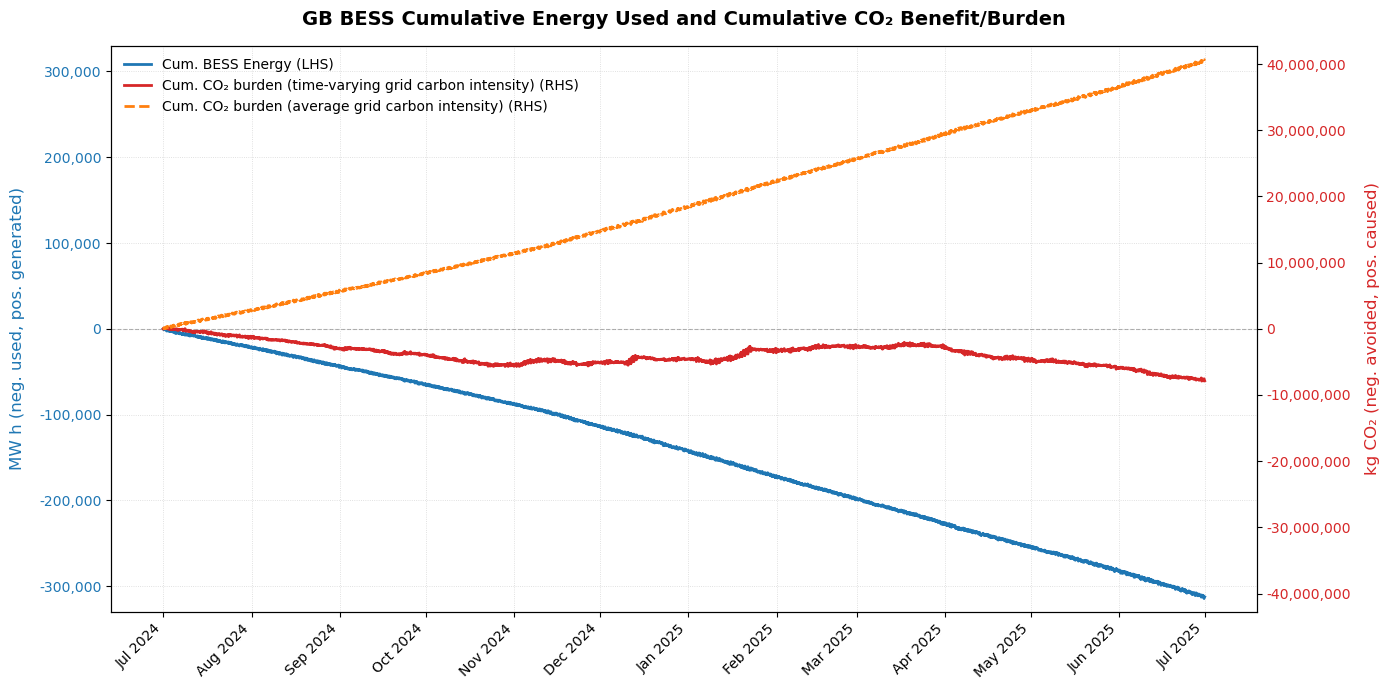

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse SettlementDate in dd/mm/yyyy format ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')

# === Sort and compute cumulative values ===
df = df.sort_values('datetime')
df['NetEnergy_MWh'] = df['BESSDischargeGB'] + df['BESSChargeGB']
df['Cum. BESS Energy'] = df['NetEnergy_MWh'].cumsum()

df['CO2_Actual_kg'] = df['NetEnergy_MWh'] * df['CarbonIntensityActualGB']
df['Cum. CO2 Actual'] = -df['CO2_Actual_kg'].cumsum()

avg_carbon_intensity = df['CarbonIntensityActualGB'].mean()
df['CO2_Avg_kg'] = df['NetEnergy_MWh'] * avg_carbon_intensity
df['Cum. CO2 Avg'] = -df['CO2_Avg_kg'].cumsum()

# === Get data ranges ===
energy = df['Cum. BESS Energy']
co2_actual = df['Cum. CO2 Actual']
co2_avg = df['Cum. CO2 Avg']

# Combine CO2 series for range check
co2_combined = pd.concat([co2_actual, co2_avg])

# === Compute symmetric ranges about zero for visual alignment ===
energy_max = energy.abs().max()
co2_max = co2_combined.abs().max()

# Optional: round to nearest nice tick
energy_lim = (-energy_max, energy_max)
co2_lim = (-co2_max, co2_max)

import matplotlib.dates as mdates

# === Plotting ===
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot primary axis
line1, = ax1.plot(df['datetime'], energy, color='tab:blue', label='Cum. BESS Energy (LHS)', linewidth=2)
ax1.set_ylabel("MW h (neg. used, pos. generated)", color='tab:blue', fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=10)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax1.set_ylim(energy_lim[0]*1.05, energy_lim[1]*1.05)

# Plot secondary axis
ax2 = ax1.twinx()
line2, = ax2.plot(df['datetime'], co2_actual, color='tab:red', label='Cum. CO₂ burden (time-varying grid carbon intensity) (RHS)', linewidth=2)
line3, = ax2.plot(df['datetime'], co2_avg, color='tab:orange', linestyle='--', label='Cum. CO₂ burden (average grid carbon intensity) (RHS)', linewidth=2)
ax2.set_ylabel("kg CO\u2082 (neg. avoided, pos. caused)", color='tab:red', fontsize=12, labelpad=10)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=10)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.set_ylim(co2_lim[0]*1.05, co2_lim[1]*1.05)

# Grid and zero lines
ax1.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.6)
ax1.grid(True, which='major', axis='both', linestyle=':', linewidth=0.6, alpha=0.5)

# X-axis formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Title and layout
plt.title("GB BESS Cumulative Energy Used and Cumulative CO\u2082 Benefit/Burden", fontsize=14, weight='bold', pad=15)
fig.tight_layout()

# Legend inside plot
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10, frameon=False)

plt.show()


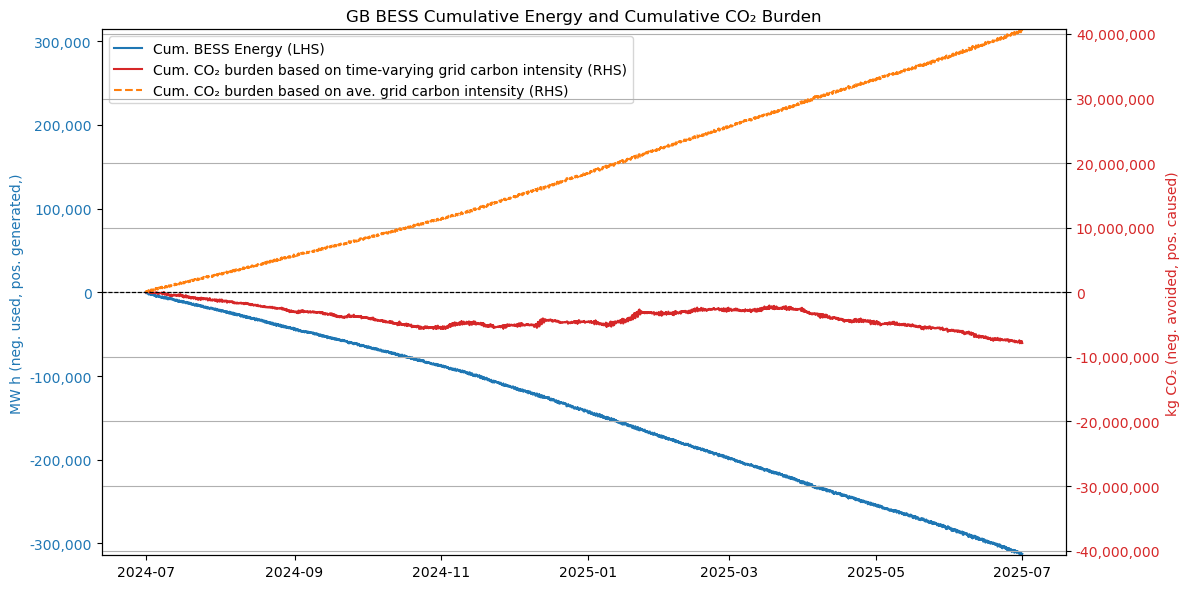

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse SettlementDate in dd/mm/yyyy format ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')

# === Sort and compute cumulative values ===
df = df.sort_values('datetime')
df['NetEnergy_MWh'] = df['BESSDischargeGB'] + df['BESSChargeGB']
df['Cum. BESS Energy'] = df['NetEnergy_MWh'].cumsum()

df['CO2_Actual_kg'] = df['NetEnergy_MWh'] * df['CarbonIntensityActualGB']
df['Cum. CO2 Actual'] = -df['CO2_Actual_kg'].cumsum()

avg_carbon_intensity = df['CarbonIntensityActualGB'].mean()
df['CO2_Avg_kg'] = df['NetEnergy_MWh'] * avg_carbon_intensity
df['Cum. CO2 Avg'] = -df['CO2_Avg_kg'].cumsum()

# === Get data ranges ===
energy = df['Cum. BESS Energy']
co2_actual = df['Cum. CO2 Actual']
co2_avg = df['Cum. CO2 Avg']

# Combine CO2 series for range check
co2_combined = pd.concat([co2_actual, co2_avg])

# === Compute symmetric ranges about zero for visual alignment ===
energy_max = energy.abs().max()
co2_max = co2_combined.abs().max()

# Optional: round to nearest nice tick
energy_lim = (-energy_max, energy_max)
co2_lim = (-co2_max, co2_max)

# === Plotting ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot primary axis
line1, = ax1.plot(df['datetime'], energy, color='tab:blue', label='Cum. BESS Energy (LHS)')
ax1.set_ylabel("MW h (neg. used, pos. generated,)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax1.set_ylim(energy_lim)

# Plot secondary axis
ax2 = ax1.twinx()
line2, = ax2.plot(df['datetime'], co2_actual, color='tab:red', label='Cum. CO₂ burden based on time-varying grid carbon intensity (RHS)')
line3, = ax2.plot(df['datetime'], co2_avg, color='tab:orange', linestyle='--', label='Cum. CO₂ burden based on ave. grid carbon intensity (RHS)')
ax2.set_ylabel("kg CO\u2082 (neg. avoided, pos. caused)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.set_ylim(co2_lim)

# Add zero lines
ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Title and layout
plt.title("GB BESS Cumulative Energy and Cumulative CO\u2082 Burden")
fig.tight_layout()
plt.grid(True)

# Legend
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.show()


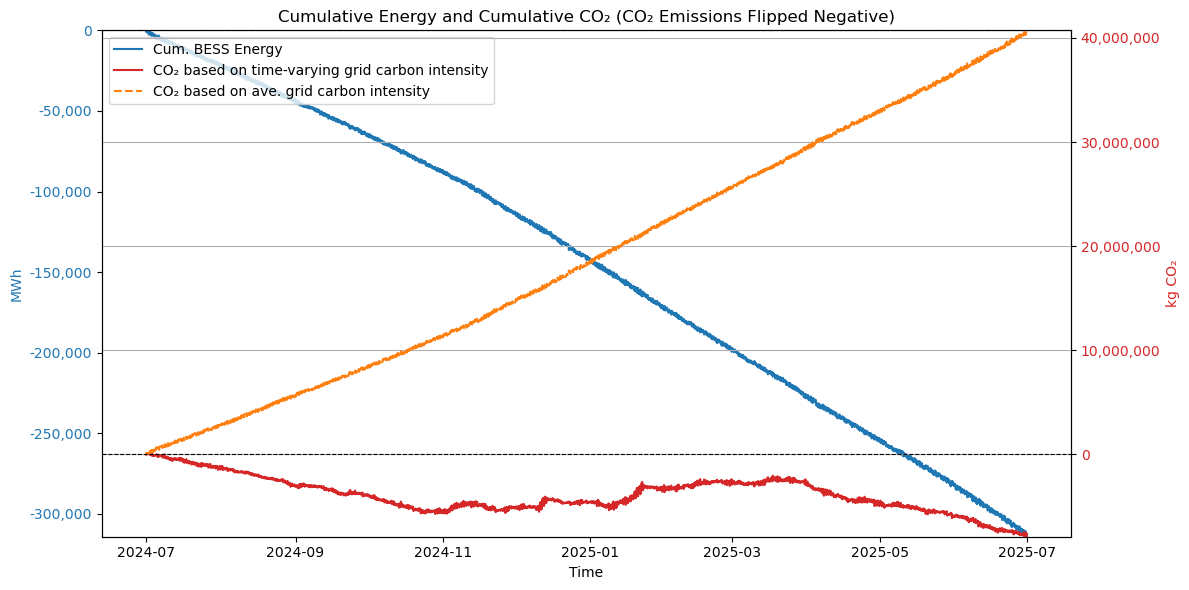

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse SettlementDate in dd/mm/yyyy format ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")

# === Create datetime column from date and period ===
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')

# === Sort by datetime to ensure correct cumulative calculations ===
df = df.sort_values('datetime')

# === Calculate net energy per period ===
df['NetEnergy_MWh'] = df['BESSDischargeGB'] + df['BESSChargeGB']
df['Cum. BESS Energy'] = df['NetEnergy_MWh'].cumsum()

# === Calculate CO₂ time series with flipped sign ===
df['CO2_Actual_kg'] = df['NetEnergy_MWh'] * df['CarbonIntensityActualGB']
df['Cum. CO2 Actual'] = -df['CO2_Actual_kg'].cumsum()

avg_carbon_intensity = df['CarbonIntensityActualGB'].mean()
df['CO2_Avg_kg'] = df['NetEnergy_MWh'] * avg_carbon_intensity
df['Cum. CO2 Avg'] = -df['CO2_Avg_kg'].cumsum()

# === Plotting ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot cumulative energy (primary y-axis)
line1, = ax1.plot(df['datetime'], df['Cum. BESS Energy'], color='tab:blue', label='Cum. BESS Energy')
ax1.set_xlabel("Time")
ax1.set_ylabel("MWh", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Secondary axis for CO₂
ax2 = ax1.twinx()
line2, = ax2.plot(df['datetime'], df['Cum. CO2 Actual'], color='tab:red', label='CO₂ based on time-varying grid carbon intensity')
line3, = ax2.plot(df['datetime'], df['Cum. CO2 Avg'], color='tab:orange', linestyle='--', label='CO₂ based on ave. grid carbon intensity')
ax2.set_ylabel("kg CO\u2082", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# === Align axes around y=0 ===
energy_min = df['Cum. BESS Energy'].min()
energy_max = df['Cum. BESS Energy'].max()
co2_min = df[['Cum. CO2 Actual', 'Cum. CO2 Avg']].min().min()
co2_max = df[['Cum. CO2 Actual', 'Cum. CO2 Avg']].max().max()

# Ensure both axes include 0
ax1.set_ylim(min(0, energy_min), max(0, energy_max))
ax2.set_ylim(min(0, co2_min), max(0, co2_max))

# Add horizontal line at y=0 for both axes
ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')

# === Title, legend, and layout ===
plt.title("Cumulative Energy and Cumulative CO\u2082 (CO\u2082 Emissions Flipped Negative)")
fig.tight_layout()
plt.grid(True)

# Add combined legend
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.show()


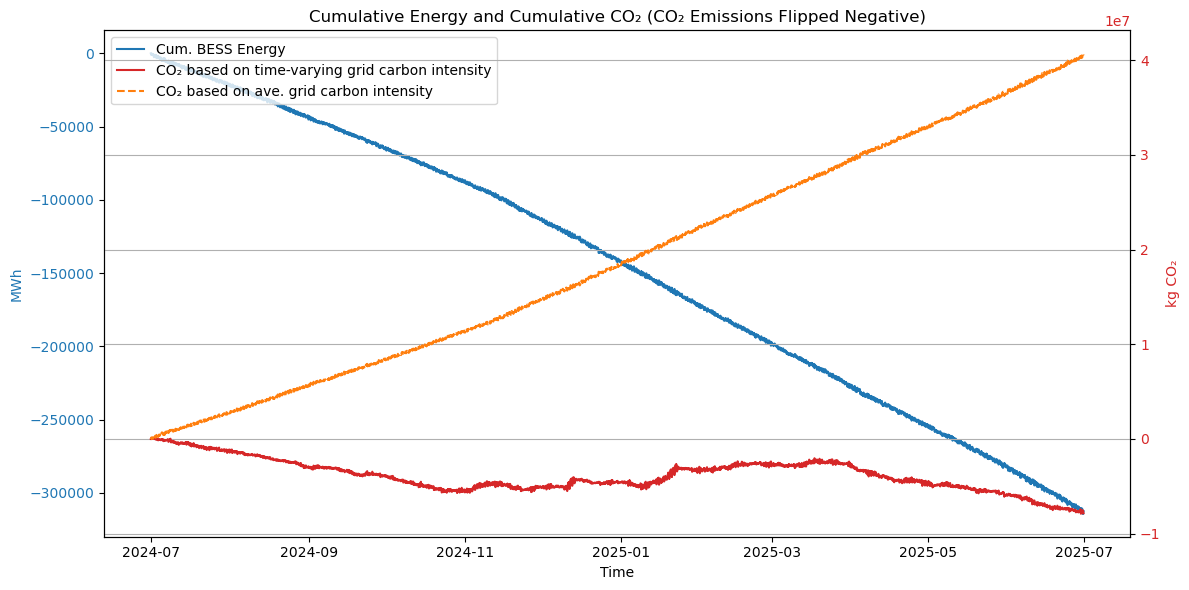

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse SettlementDate in dd/mm/yyyy format ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")

# === Create datetime column from date and period ===
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')

# === Sort by datetime to ensure correct cumulative calculations ===
df = df.sort_values('datetime')

# === Calculate net energy per period ===
df['NetEnergy_MWh'] = df['BESSDischargeGB'] + df['BESSChargeGB']

# === Cumulative energy ===
df['Cum. BESS Energy'] = df['NetEnergy_MWh'].cumsum()

# === Cumulative CO₂ using actual time-varying grid intensity, flipped sign ===
df['CO2_Actual_kg'] = df['NetEnergy_MWh'] * df['CarbonIntensityActualGB']
df['Cum. CO2 Actual'] = -df['CO2_Actual_kg'].cumsum()  # Flipped sign

# === Cumulative CO₂ using average grid intensity, flipped sign ===
avg_carbon_intensity = df['CarbonIntensityActualGB'].mean()
df['CO2_Avg_kg'] = df['NetEnergy_MWh'] * avg_carbon_intensity
df['Cum. CO2 Avg'] = -df['CO2_Avg_kg'].cumsum()  # Flipped sign

# === Plotting ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot cumulative energy (primary y-axis)
line1, = ax1.plot(df['datetime'], df['Cum. BESS Energy'], color='tab:blue', label='Cum. BESS Energy')
ax1.set_xlabel("Time")
ax1.set_ylabel("MWh", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot CO₂ (secondary y-axis, flipped)
ax2 = ax1.twinx()
line2, = ax2.plot(df['datetime'], df['Cum. CO2 Actual'], color='tab:red', label='CO₂ based on time-varying grid carbon intensity')
line3, = ax2.plot(df['datetime'], df['Cum. CO2 Avg'], color='tab:orange', linestyle='--', label='CO₂ based on ave. grid carbon intensity')
ax2.set_ylabel("kg CO\u2082", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout
plt.title("Cumulative Energy and Cumulative CO\u2082 (CO\u2082 Emissions Flipped Negative)")
fig.tight_layout()
plt.grid(True)

# Add combined legend
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.show()


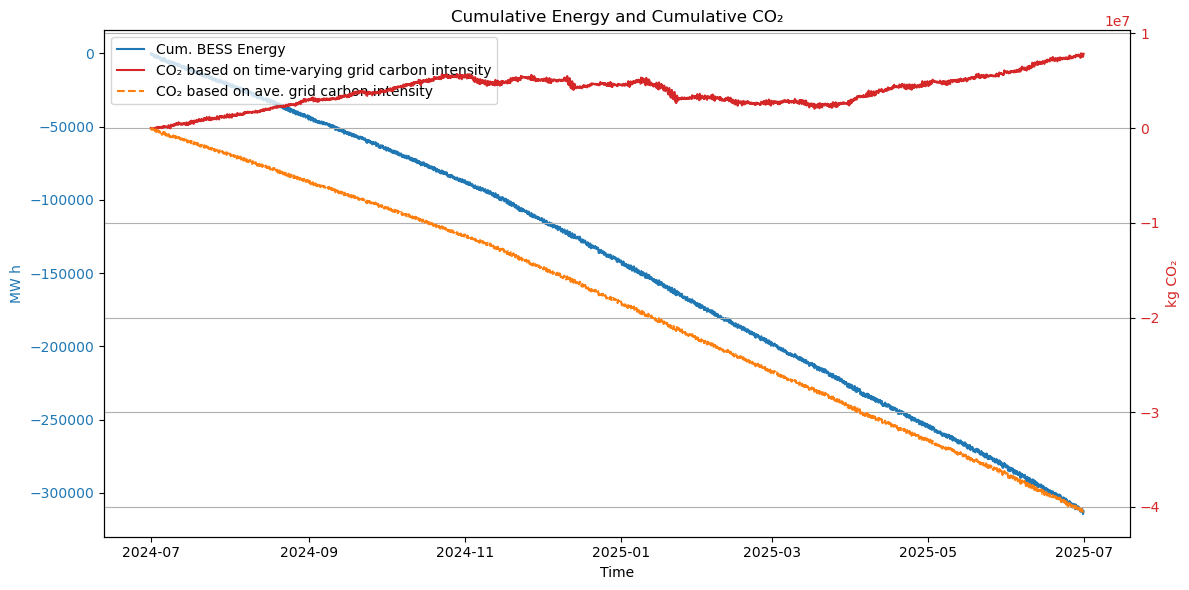

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse SettlementDate in dd/mm/yyyy format ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")

# === Create datetime column from date and period ===
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')

# === Sort by datetime to ensure correct cumulative calculations ===
df = df.sort_values('datetime')

# === Calculate net energy per period ===
df['NetEnergy_MWh'] = df['BESSDischargeGB'] + df['BESSChargeGB']

# === Cumulative energy ===
df['Cum. BESS Energy'] = df['NetEnergy_MWh'].cumsum()

# === Cumulative CO₂ using actual time-varying grid intensity ===
df['CO2_Actual_kg'] = df['NetEnergy_MWh'] * df['CarbonIntensityActualGB']
df['Cum. CO2 Actual'] = df['CO2_Actual_kg'].cumsum()

# === Cumulative CO₂ using average grid intensity ===
avg_carbon_intensity = df['CarbonIntensityActualGB'].mean()
df['CO2_Avg_kg'] = df['NetEnergy_MWh'] * avg_carbon_intensity
df['Cum. CO2 Avg'] = df['CO2_Avg_kg'].cumsum()

# === Plotting ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot cumulative energy (primary y-axis)
line1, = ax1.plot(df['datetime'], df['Cum. BESS Energy'], color='tab:blue', label='Cum. BESS Energy')
ax1.set_xlabel("Time")
ax1.set_ylabel("MW h", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot CO₂ (secondary y-axis)
ax2 = ax1.twinx()
line2, = ax2.plot(df['datetime'], df['Cum. CO2 Actual'], color='tab:red', label='CO₂ based on time-varying grid carbon intensity')
line3, = ax2.plot(df['datetime'], df['Cum. CO2 Avg'], color='tab:orange', linestyle='--', label='CO₂ based on ave. grid carbon intensity')
ax2.set_ylabel("kg CO\u2082", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout
plt.title("Cumulative Energy and Cumulative CO\u2082")
fig.tight_layout()
plt.grid(True)

# Add combined legend
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.show()


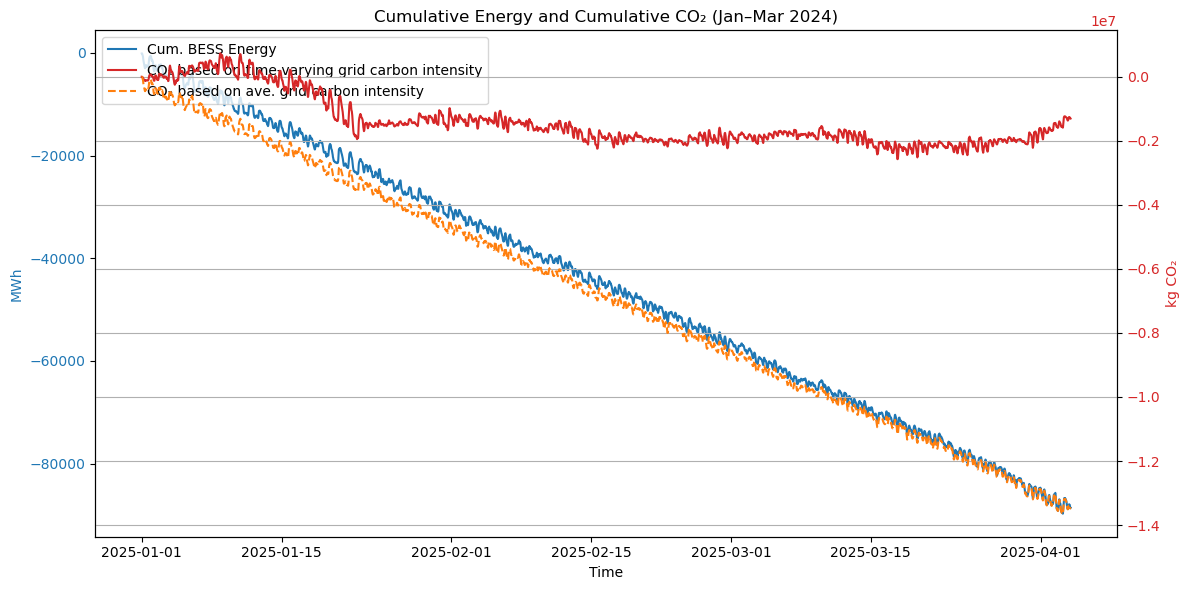

In [6]:
#This version only does the above chart from 1 Jan to 4 April

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# === Load data ===
file_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(file_path)

# === Parse SettlementDate in dd/mm/yyyy format ===
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")

# === Create datetime column from date and period ===
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')

# === Filter to 1 Jan 2024 – 4 Mar 2024 ===
start_date = pd.to_datetime("01/01/2025", format="%d/%m/%Y")
end_date = pd.to_datetime("04/04/2025", format="%d/%m/%Y")
df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

# === Sort by datetime to ensure correct cumulative calculations ===
df = df.sort_values('datetime')

# === Calculate net energy per period ===
df['NetEnergy_MWh'] = df['BESSDischargeGB'] + df['BESSChargeGB']

# === Cumulative energy ===
df['Cum. BESS Energy'] = df['NetEnergy_MWh'].cumsum()

# === Cumulative CO₂ using actual time-varying grid intensity ===
df['CO2_Actual_kg'] = df['NetEnergy_MWh'] * df['CarbonIntensityActualGB']
df['Cum. CO2 Actual'] = df['CO2_Actual_kg'].cumsum()

# === Cumulative CO₂ using average grid intensity (based on this period only) ===
avg_carbon_intensity = df['CarbonIntensityActualGB'].mean()
df['CO2_Avg_kg'] = df['NetEnergy_MWh'] * avg_carbon_intensity
df['Cum. CO2 Avg'] = df['CO2_Avg_kg'].cumsum()

# === Plotting ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot cumulative energy (primary y-axis)
line1, = ax1.plot(df['datetime'], df['Cum. BESS Energy'], color='tab:blue', label='Cum. BESS Energy')
ax1.set_xlabel("Time")
ax1.set_ylabel("MWh", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot CO₂ (secondary y-axis)
ax2 = ax1.twinx()
line2, = ax2.plot(df['datetime'], df['Cum. CO2 Actual'], color='tab:red', label='CO₂ based on time-varying grid carbon intensity')
line3, = ax2.plot(df['datetime'], df['Cum. CO2 Avg'], color='tab:orange', linestyle='--', label='CO₂ based on ave. grid carbon intensity')
ax2.set_ylabel("kg CO\u2082", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout
plt.title("Cumulative Energy and Cumulative CO\u2082 (Jan–Mar 2024)")
fig.tight_layout()
plt.grid(True)

# Add combined legend
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.show()
